In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates.angles import Angle

from astropy.time import Time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
_Lon = (106. + 51./60. + 24.0/3600.) * u.deg
_Lat = (25. + 39./60. + 10.6/3600.) * u.deg
_Location = EarthLocation.from_geodetic(_Lon, _Lat)

def get_pointing_any_scan(time, alt0, az0, time_format='unix', feed_rotation=0):
    
    '''
    estimate the pointing RA Dec accoriding obs time and init Dec 
    for drift scan pointing at meridian
    
    time: obs time
    '''

    if alt0 > 90.: alt0=90.
    za0  = 90. - alt0
    za0 = np.float64((za0 * u.deg).to(u.radian).value)
    az0 = np.float64((az0 * u.deg).to(u.radian).value)

    # position of 19 beam in unit or arcmin, from Wenkai's calculation
    # already rotated by 23.4 deg
    x_position = np.array([  0.000,   5.263,   0.659,  -4.604,  -5.263,
                            -0.659,   4.604,  10.526,   5.922,   1.318,
                            -3.945,  -9.208,  -9.867, -10.526,  -5.922,
                            -1.318,   3.945,   9.208,   9.867], dtype='float64')
    y_position = np.array([  0.000,  -2.277,  -5.6965, -3.419,   2.277,
                             5.6965,  3.419,  -4.555,  -7.974, -11.393,
                             -9.116, -6.838,  -1.142,   4.555,   7.974,
                             11.393,  9.116,   6.838,   1.142], dtype='float64')

    separation = np.sqrt(x_position ** 2 + y_position ** 2) * u.arcmin
    position_angle  = np.arctan2(x_position, y_position) * u.rad - 23.4 * u.deg
    position_angle += feed_rotation * u.deg
    
    separation = separation.to(u.radian).value
    position_angle = position_angle.to(u.radian).value
    position_angle += az0
    position_angle[position_angle > np.pi] -= 2. * np.pi
    position_angle[position_angle < -np.pi] += 2. * np.pi
    #for i in range(19):
    #    print '%2d'%(i+1), '%12.6f'%(position_angle[i] * 180./np.pi), \
    #          '%12.6f'%((position_angle[i] + az0) * 180./np.pi)
    
    sign = (position_angle) / np.abs(position_angle)
    
    position_angle[0] = 0.
    separation[0] = 0.

    za = np.cos(za0) * np.cos(separation) + np.sin(za0) * np.sin(separation) * np.cos(position_angle)
    za = np.arccos(za)
    
    if za0 != 0:
        daz = (- np.cos(za0) * np.cos(za) + np.cos(separation)) / np.sin(za0)/ np.sin(za)
    
        daz[daz<-1] = -1
        daz[daz>1]  = 1
        #print daz.min(), daz.max()
        daz = np.arccos(daz) * sign
        
    else:
        daz = position_angle - 2 * az0

    az = Angle(az0 + daz, u.radian) 
    za = Angle(za, u.radian)
    alt = 90.*u.deg - za
    
    #for i in range(19):
    #    print '%3d'%i, '%3dd%3dm%6.2fs'%alt[i].dms,  '%6dd%3dm%6.2fs'%az[i].dms
    
    
    _t, _alt, _az = np.broadcast_arrays(time[:, None], alt[None, :].deg, az[None, :].deg)
    _t = Time(_t, format=time_format, location=_Location)
    _alt = Angle(_alt, u.deg)
    _az  = Angle(_az,  u.deg)
    c0   = SkyCoord(alt=_alt, az=_az, frame='altaz', location=_Location, obstime=_t)
    c0   = c0.transform_to('icrs')
    

    return az.deg, alt.deg, c0.ra.deg, c0.dec.deg

def project_to_antenna_coord(alt, az, alt0=None, az0=None):
    
    if alt0 is None: alt0 = alt[0]
    if az0  is None: az0  = az[0]
    y = alt - alt0
    x = (az  - az0) * np.cos(alt * np.pi / 180.)
    
    return x, y

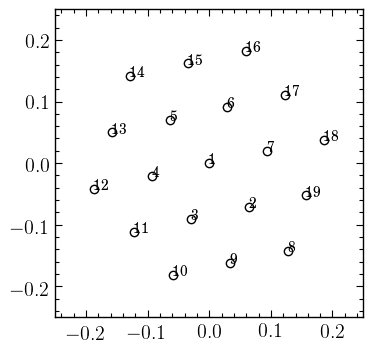

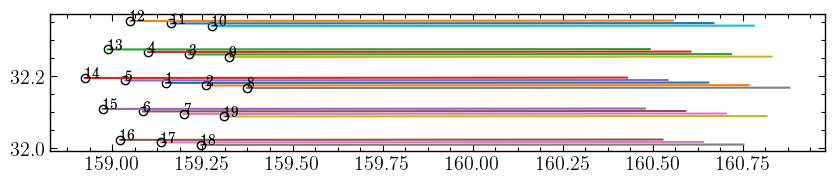

In [6]:
'''
Test coord
'''
# assume some time and pointing
time = Time('2020-05-05 12:00:00') + np.linspace(0, 0.1, 100) * u.hour
alt0  = 80.
az0   = 48.

# get pointing of each beam
az, alt, ra, dec = get_pointing_any_scan(time.unix, alt0, az0, feed_rotation=0)

# plot beam coord in ant. coord
fig = plt.figure(figsize=[4, 4])
ax  = fig.add_subplot(111)
x, y = project_to_antenna_coord(alt, az)
for i in range(19):
    ax.plot(x[i], y[i], 'ko', mfc='none')
    ax.text(x[i], y[i], '%2d'%(i+1))
ax.set_aspect('equal')
ax.set_xlim(-0.25, 0.25)
ax.set_ylim(-0.25, 0.25)

# plot beam coord in RA Dec coord
# with alt0 lower than 80 and az!=0 or 180, beams in the same line are scanning different dec
fig = plt.figure(figsize=[10, 6])
ax  = fig.add_subplot(111)
for i in range(19):
    ax.plot(ra[:, i], dec[:, i])
    ax.plot(ra[0, i], dec[0, i], 'ko', mfc='none')
    ax.text(ra[0, i], dec[0, i], '%2d'%(i+1))

ax.set_aspect('equal')

  0  13h31m8.2880s   30d30m32.9589s 
  1  13h31m8.2880s   30d30m32.9589s 
  2  13h31m8.2880s   30d30m32.9589s 
  3  13h31m8.2880s   30d30m32.9589s 
  4  13h31m8.2880s   30d30m32.9589s 
  5  13h31m8.2880s   30d30m32.9589s 
  6  13h31m8.2880s   30d30m32.9589s 
  7  13h31m8.2880s   30d30m32.9589s 
  8  13h31m8.2880s   30d30m32.9589s 
  9  13h31m8.2880s   30d30m32.9589s 
 10  13h31m8.2880s   30d30m32.9589s 
 11  13h31m8.2880s   30d30m32.9589s 
 12  13h31m8.2880s   30d30m32.9589s 
 13  13h31m8.2880s   30d30m32.9589s 
 14  13h31m8.2880s   30d30m32.9589s 
 15  13h31m8.2880s   30d30m32.9589s 
 16  13h31m8.2880s   30d30m32.9589s 
 17  13h31m8.2880s   30d30m32.9589s 
 18  13h31m8.2880s   30d30m32.9589s 
 19  13h31m8.2880s   30d30m32.9589s 
 20  13h31m8.2880s   30d30m32.9589s 
 21  13h31m8.2880s   30d30m32.9589s 
 22  13h31m8.2880s   30d30m32.9589s 
 23  13h31m8.2880s   30d30m32.9589s 
 24  13h31m8.2880s   30d30m32.9589s 


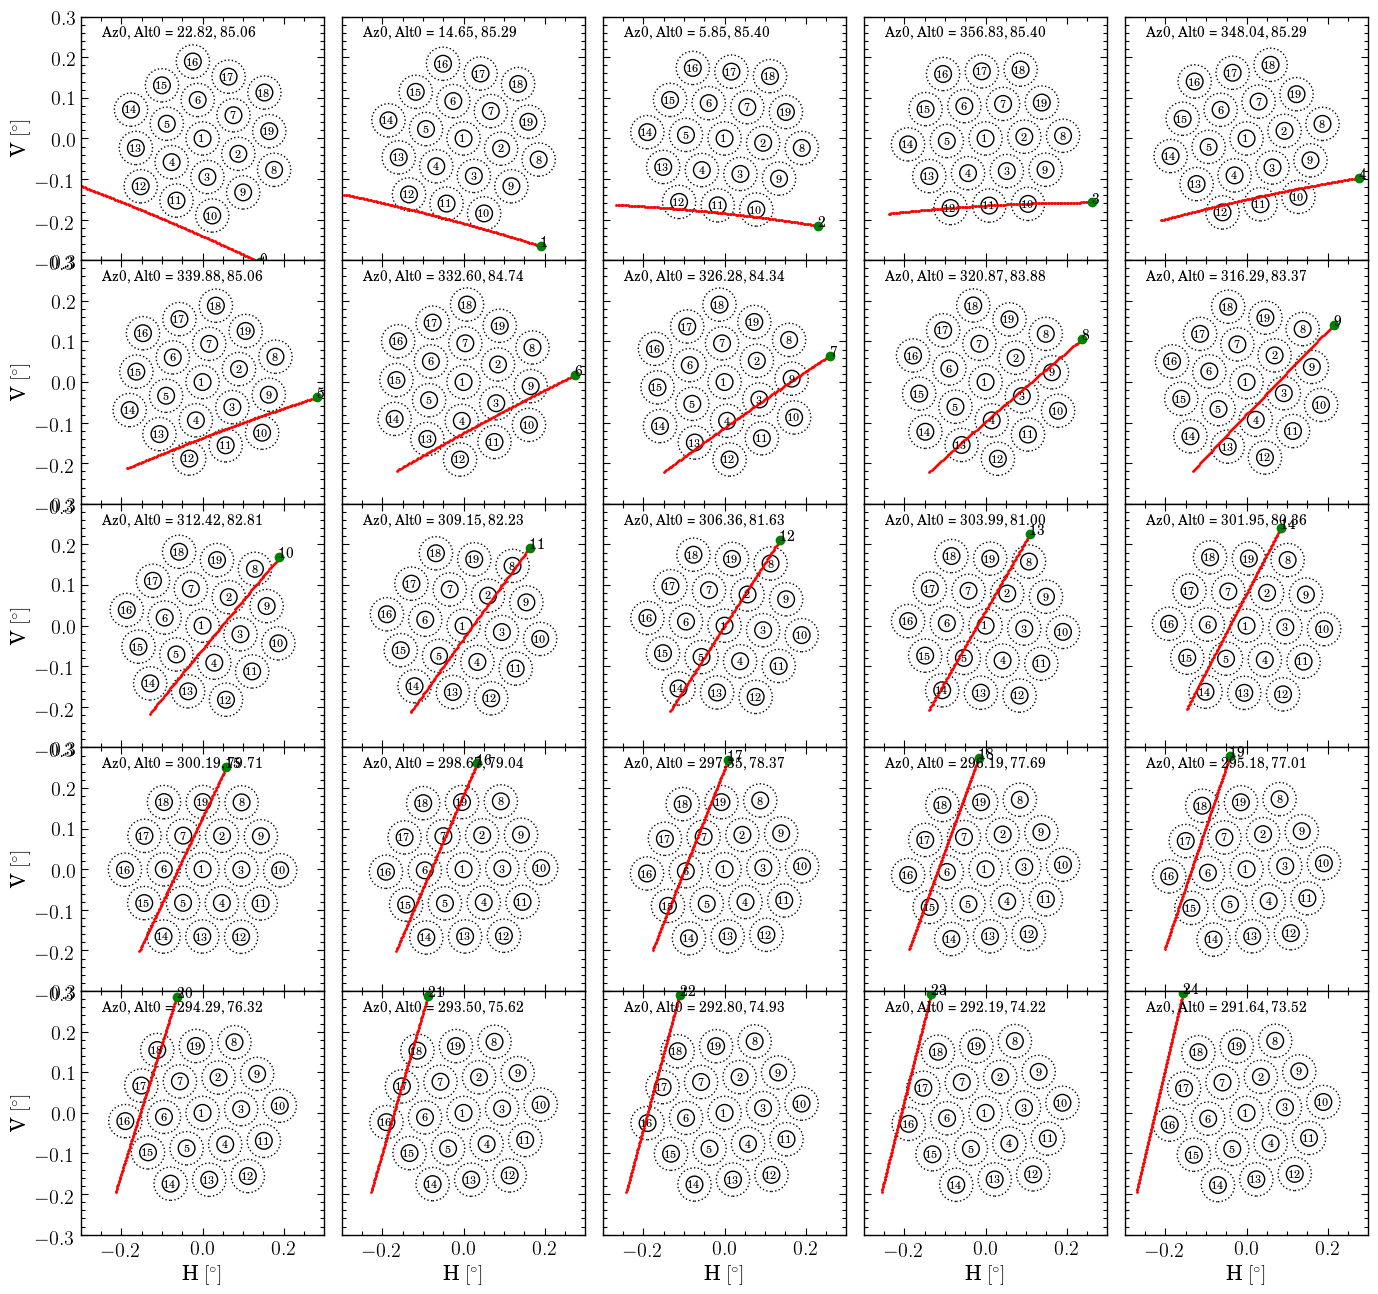

In [7]:
# simulate calibrator scans. 


fwhm = 2.9 / 60. / (2. * np.log(2.))**0.5
n_scans = 25
n_col = 5
n_row = int(np.ceil(n_scans / float(n_col)))
fig = plt.figure(figsize=[15, 14])
gs = gridspec.GridSpec(n_row , n_col, 
                       left=0.08, bottom=0.08, right=0.95, top=0.95, wspace=0.0, hspace=0.0)

start_time = '2020-05-05 15:20:00'
loading_time = 1 * u.minute
dt = 140. * u.second + loading_time
for ii, ddec in enumerate(np.linspace(-0.22, 0.22, n_scans)):
    
    ax = fig.add_subplot(gs[ii//n_col, ii - ii//n_col * n_col])

    time = Time(start_time) + np.arange(-70, 70, 1) * u.second + dt * ii
    mid = len(time) // 2
    #print mid, len(time)
    cal_ra = Angle('13h31m08.287984s')
    cal_dec = Angle('30d30m32.958850s') #+ ddec * u.deg
    print '%3d %3dh%2dm%6.4fs  %3dd%2dm%6.4fs '%((ii, ) + cal_ra.hms + cal_dec.dms)
    cal = SkyCoord(cal_ra, cal_dec)
    obs = AltAz(location=_Location, obstime = time)
    cal_altaz = cal.transform_to(obs)
    cal_alt, cal_az = cal_altaz.alt.deg, cal_altaz.az.deg
    
    # pointing offset 
    p_ra = Angle('13h31m08.287984s')
    p_dec = Angle('30d30m32.958850s') + ddec * u.deg
    p = SkyCoord(p_ra, p_dec)
    p_altaz = p.transform_to(obs)
    p_alt, p_az = p_altaz.alt.deg, p_altaz.az.deg
    alt0 = p_alt[mid]
    az0  = p_az[mid]
    az, alt, ra, dec = get_pointing_any_scan(time.unix, alt0, az0, feed_rotation=0)
    
    cal_x, cal_y = project_to_antenna_coord(cal_alt, cal_az, alt0, az0)
    x, y = project_to_antenna_coord(alt, az, alt0, az0)
    
    
    for i in range(19):
        #ax.plot(x[i], y[i], 'ko', mfc='none')
        ax.add_artist(plt.Circle((x[i], y[i]), fwhm/2., color='k', fill=False))
        ax.add_artist(plt.Circle((x[i], y[i]), fwhm, color='k', linestyle=':', fill=False))
        ax.text(x[i], y[i], '%d'%(i+1), ha='center', va='center', size=8)
    
    ax.text(-0.25, 0.25, 'Az0, Alt0 = %5.2f, %5.2f' % (az0, alt0))

    ax.plot(cal_x, cal_y, 'r.', ms=2)
    ax.plot(cal_x[0], cal_y[0], 'go')
    ax.text(cal_x[0], cal_y[0], '%2d'%ii)
    ax.set_aspect('equal')
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
    if ii // n_col == n_row - 1:
        ax.set_xlabel(r'H $[^\circ]$')
    else:
        ax.set_xticklabels([])
    if ii - ii//n_col * n_col == 0:
        ax.set_ylabel(r'V $[^\circ]$')
    else:
        ax.set_yticklabels([])
    #ax.set_title('Ant. Coord.')


In [8]:
'''
test beam position
'''
x_position = np.array([  0.000,   5.263,   0.659,  -4.604,  -5.263,
                        -0.659,   4.604,  10.526,   5.922,   1.318,
                        -3.945,  -9.208,  -9.867, -10.526,  -5.922,
                        -1.318,   3.945,   9.208,   9.867])
y_position = np.array([  0.000,  -2.277,  -5.6965, -3.419,   2.277,
                         5.6965,  3.419,  -4.555,  -7.974, -11.393,
                        -9.1160, -6.838,  -1.142,   4.555,   7.974,
                         11.393,  9.116,   6.838,   1.142])

separation = np.sqrt(x_position ** 2 + y_position ** 2) * u.arcmin
position_angle  = np.arctan2(x_position, -y_position) * u.rad + 23.4 * u.deg
position_angle[0]
for i in range(19):
    a = Angle(separation[i])
    b = Angle(position_angle[i])
    print '%2d'%(i+1), '%3dd%3dm%6.2fs'%a.dms, '%6dd%3dm%6.2fs'%b.dms

 1   0d  0m  0.00s    203d 24m  0.00s
 2   0d  5m 44.07s     90d  0m 16.62s
 3   0d  5m 44.07s     29d 59m 56.16s
 4   0d  5m 44.08s    -30d  0m -6.70s
 5   0d  5m 44.07s    -89d-59m-43.38s
 6   0d  5m 44.07s   -150d  0m -3.84s
 7   0d  5m 44.08s    149d 59m 53.30s
 8   0d 11m 28.16s     90d  0m  0.11s
 9   0d  9m 55.95s     59d 59m 59.75s
10   0d 11m 28.14s     29d 59m 56.16s
11   0d  9m 55.98s      0d  0m -2.95s
12   0d 11m 28.16s    -30d  0m -6.70s
13   0d  9m 55.97s    -59d-59m-52.80s
14   0d 11m 28.16s    -89d-59m-59.89s
15   0d  9m 55.95s   -120d  0m -0.25s
16   0d 11m 28.14s   -150d  0m -3.84s
17   0d  9m 55.98s    179d 59m 57.05s
18   0d 11m 28.16s    149d 59m 53.30s
19   0d  9m 55.97s    120d  0m  7.20s
